# Tackling the Health Crises in Africa
### by Esosa Orumwese

## Introduction
The lack of access to adequate medical resources and facilities have led to the significant number of deaths. Some of these deaths could have been avoided by timely access to a medical professional or close proximity of hospitals.

Health systems across Africa are underfunded and understaffed. Less than half of African citizens (52%) about 615 million people have access to the health care they need, the quality of health services across the continent is generally poor, and family planning needs of half the continent’s women and girls are unmet.

This is an analysis on healthcare data relating to deaths, causes of deaths, national healthcare expenditure, and distribution of medical doctors in Africa.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# suppressing SettingWithCopyWarning
pd.options.mode.chained_assignment = None # default='warn'

plt.style.use('seaborn-dark-palette')
%matplotlib inline

## Data Wrangling

In [84]:
# load data
worldCountries = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=0)
causesofDeath = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=1, parse_dates=['Year'])
ageGroupDeaths = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=2, parse_dates=['Year'])
doctorsPerPopulation = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=3, parse_dates=['Year'])
healthExpenditure = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=4, parse_dates=['Year'])
africanCountries = pd.read_excel('./data/World Healthcaredata.xlsx', sheet_name=5)
worldPopulation = pd.read_csv('./data/5. World Population.csv')

In [85]:
ageGroupDeaths['Age_Group'] = ageGroupDeaths.Age_Group.str.replace(pat='Under 5', repl='Under 5 years')

In [86]:
# order in increasing age
ageRange = ['Under 5 years', '5-14 years', '15-49 years', '50-69 years', '70+ years']

# creating the CategoricalDtype
ageRange_class = pd.api.types.CategoricalDtype(categories=ageRange, ordered=True)

# applying convertion to variables in dataframe
ageGroupDeaths['Age_Group'] = ageGroupDeaths['Age_Group'].astype(ageRange_class)

In [87]:
ageGroupDeaths = ageGroupDeaths.query('Year >= 2000 & Year < 2020')
doctorsPerPopulation = doctorsPerPopulation.query('Year >= 2000 & Year < 2020')
healthExpenditure = healthExpenditure.query('Year >= 2000 & Year < 2020')
worldPopulation = worldPopulation.query('Year >= 2000 & Year < 2020')
worldPopulation['Year'] = pd.to_datetime(worldPopulation.Year, format='%Y')

## Exploratory Analysis
Let's use data from 2000 upwards

## What proportion of the world's population died due to health related issues?
Asia, Africa and Europe have contributed more than 80% to the total health related deaths. Asia has the largest death, with an alarming 54.18% dead due to health related issues between 2000 and 2019. 

It's interesting to note that there is just a rough 2% difference in contribution to percentage deaths between Africa and Europe.

In [88]:
causesofDeath_agg_sum = causesofDeath.groupby('Entity').sum()
causesofDeath_merge = pd.merge(left=causesofDeath, right=worldCountries, how='inner', left_on='Code', right_on='Three_Letter_Country_Code')
causesofDeath_merge = causesofDeath_merge.drop(labels=['Entity', 'Country_Number'], axis=1)
causesofDeath_merge = causesofDeath_merge.iloc[:,[6,1,2,3,7,8,4,5]]
causesofDeath_merge = causesofDeath_merge[causesofDeath_merge.Year >= '2000-01-01']

In [89]:
rangeOfYears = causesofDeath_merge.groupby('Country_Name').nunique()

dropCountries = ['Hong Kong', 'Western Sahara']
causesofDeath_merge = causesofDeath_merge.query('Country_Name not in @dropCountries')

In [90]:
casecount_per_continent = causesofDeath_merge.groupby('Continent_Name').sum()

# let's get the value in percentages
casecount_per_continent['Percentage'] = casecount_per_continent['Case_Count']*100/casecount_per_continent.Case_Count.sum()
casecount_per_continent['Percentage'] = casecount_per_continent['Percentage'].round(2)

In [91]:
base_color = sns.color_palette()[5]

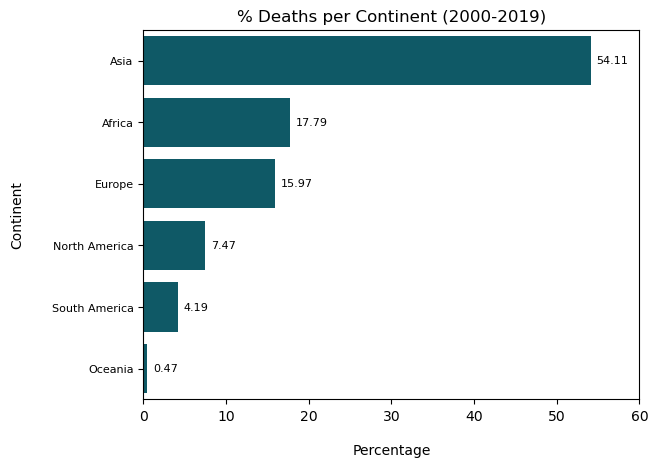

In [92]:
plotData = casecount_per_continent.Percentage
bar_order = plotData.sort_values(ascending=False).index

ax = sns.barplot(y=plotData.index, x=plotData.values, order=bar_order, color=base_color)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,60)
plt.xlabel('Percentage', labelpad=15)
plt.ylabel('Continent', labelpad=20)
plt.yticks(fontsize=8)
plt.title('% Deaths per Continent (2000-2019)');

Let's compare it taking population into account.

In [93]:
propCaseCount_per_continent = causesofDeath_merge.groupby(['Continent_Name', 'Year']).sum()
causesofDeath_merge['Year_str'] = causesofDeath_merge.Year.dt.year.astype('str')
causesofDeath_merge['Key'] = causesofDeath_merge['Three_Letter_Country_Code']+causesofDeath_merge['Year_str']
worldPopulation['Year_str'] = worldPopulation.Year.dt.year.astype('str')
worldPopulation['Key'] = worldPopulation['Code']+worldPopulation['Year_str']

In [94]:
causesofDeath_merge = pd.merge(left=causesofDeath_merge, right=worldPopulation.iloc[:,[3,5]], how='inner', on='Key')
causesofDeath_merge = causesofDeath_merge.drop(labels=['Year_str', 'Key'], axis=1)
causesofDeath_merge['death_per_population'] = causesofDeath_merge['Case_Count']/causesofDeath_merge['Population (historical estimates)']

In [95]:
pop_casecount_per_continent = causesofDeath_merge.groupby('Continent_Name').sum()

# let's get the value in percentages
pop_casecount_per_continent['Percentage'] = pop_casecount_per_continent['death_per_population']*100/pop_casecount_per_continent.death_per_population.sum()
pop_casecount_per_continent['Percentage'] = pop_casecount_per_continent['Percentage'].round(2)

In [96]:
pop_casecount_per_continent

,Case_Count,Population (historical estimates),death_per_population,Percentage
Continent_Name,,,,
Africa,167975394,441862222872,9.164663,30.68
Asia,510936239,1758166893798,5.230784,17.51
Europe,150842704,308007794745,8.178055,27.38
North America,70561305,226083494700,3.284993,11.00
Oceania,4438408,15261916026,2.716828,9.09
South America,39558091,163901104122,1.298761,4.35


### Accounting for population

We can see that Africa and Europe both surpass Asia by about roughly 11% each. Africa tops others with 30.68% of the population estimated to be lost due to health issues, followed by Europe with 27.38%. It's worth nothing that South America and Oceania both have low deaths per population. Further research can be done to highlight why this is so and how this can be replicated in the top 3 continents. We'll focus on Africa for this analysis.

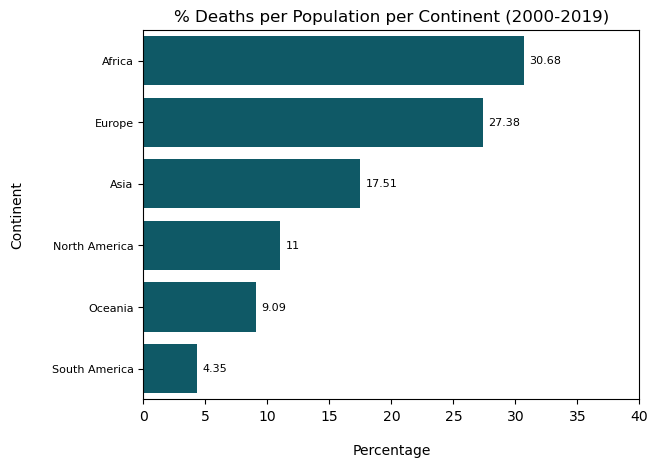

In [97]:
plotData = pop_casecount_per_continent.Percentage
bar_order = plotData.sort_values(ascending=False).index

ax = sns.barplot(y=plotData.index, x=plotData.values, order=bar_order, color=base_color)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,40)
plt.xlabel('Percentage', labelpad=15)
plt.ylabel('Continent', labelpad=20)
plt.yticks(fontsize=8)
plt.title('% Deaths per Population per Continent (2000-2019)');

## What are the best and worst performing countries in Africa?
The chart above shows that Lesotho, Central African Republic and Eritrea top all other African countries with 3.51%, 3.03% and 2.88% respectively. Nigeria had the 20th position with 2.05% of its population dead due to health related uses. Libya, Algeria and Tunisia had the least % deaths per population with 0.7%, 0.87% and 1.03% respectively.

In [98]:
causesofDeath_africa = causesofDeath_merge.query('Continent_Name == "Africa"')
pop_casecount_africa = causesofDeath_africa.groupby('Country_Name').sum()

# let's get the value in percentages
pop_casecount_africa['Percentage'] = pop_casecount_africa['death_per_population']*100/pop_casecount_africa.death_per_population.sum()
pop_casecount_africa['Percentage'] = pop_casecount_africa['Percentage'].round(2)

''

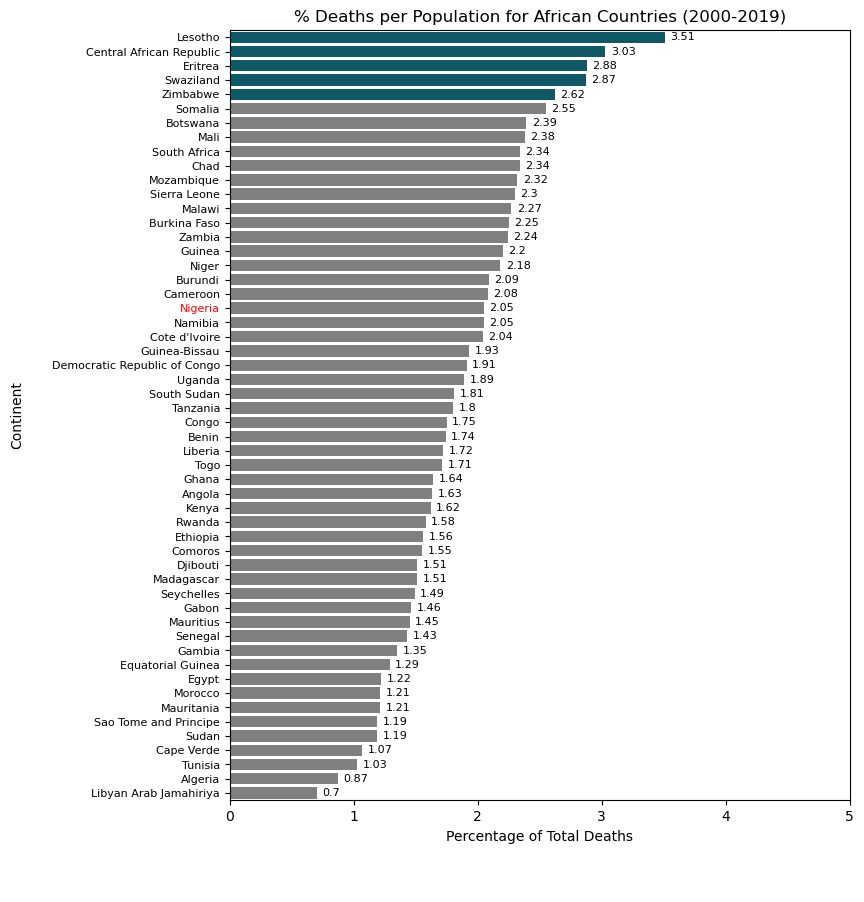

In [99]:
plotData = pop_casecount_africa.Percentage
plotData = plotData.sort_values(ascending=False)

# bar color
bar_clrs = ['grey' if (x < 2.6) else base_color for x in plotData.values ]

plt.figure(figsize=[8,10])
ax = sns.barplot(y=plotData.index, x=plotData.values, palette=bar_clrs)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,5)
plt.xlabel('Percentage of Total Deaths\n\n\n')
plt.ylabel('Continent', labelpad=20)
plt.yticks(fontsize=8)
plt.title('% Deaths per Population for African Countries (2000-2019)')

# change tick color
ytick_clrs = ['red' if (x == 'Nigeria') else 'black' for x in plotData.index ]

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), ytick_clrs):
      ticklabel.set_color(tickcolor)
;

## How does Nigeria compare to the top 5 Countries over the years?
Percentage of Deaths for Lesotho, Swaziland and Zimbabwe all peaked between 2004 and 2005 with percentages of 1.91%, 1.71% and 1.57%. Overall, there was a 0.448% decrease in deaths per population for the worst 5 countries while Nigeria experienced a sharp drop of 1.182% in the last 20 years.

In [100]:
pop_casecount_africa_timeseries = causesofDeath_africa.groupby(['Country_Name','Year']).sum()
pop_casecount_africa_timeseries = pop_casecount_africa_timeseries.reset_index()

topFourCountries = ['Lesotho', 'Central African Republic', 'Eritrea', 'Swaziland', 'Zimbabwe', 'Nigeria']

pop_casecount_topFourAfrica = pop_casecount_africa_timeseries.query('Country_Name in @topFourCountries')
pop_casecount_topFourAfrica['Year_int'] = pop_casecount_topFourAfrica.Year.dt.year
pop_casecount_topFourAfrica['pct_deaths_per_pop'] = pop_casecount_topFourAfrica['death_per_population'] * 100

In [101]:
viewData = pop_casecount_topFourAfrica.groupby(['Country_Name', 'Year_int']).sum()[['pct_deaths_per_pop']].reset_index()
viewData = viewData.pivot(index='Year_int', columns='Country_Name', values='pct_deaths_per_pop')

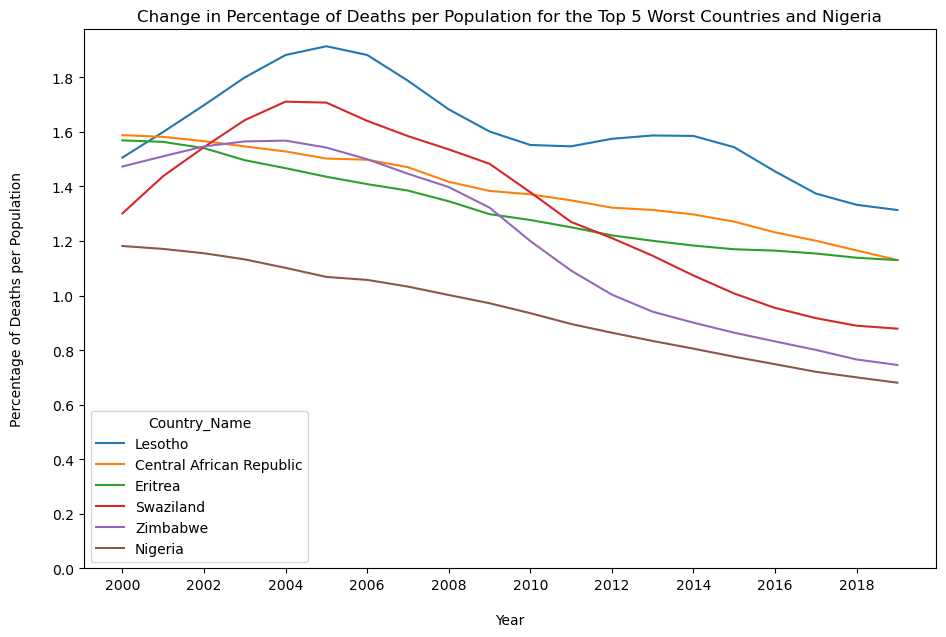

In [102]:
plt.figure(figsize=[11,7])
sns.lineplot(x='Year', y='pct_deaths_per_pop', data=pop_casecount_topFourAfrica,
             hue='Country_Name', hue_order=topFourCountries, palette='tab10')
plt.yticks(ticks=np.arange(0,2,0.2))
plt.xlabel('Year', labelpad=15)
plt.ylabel('Percentage of Deaths per Population', labelpad=20)
plt.title('Change in Percentage of Deaths per Population for the Top 5 Worst Countries and Nigeria');

## What causes are responsible for most of the deaths in Africa?
For the period of 2000 to 2019, Cardiovascular diseases (15.86%) and HIV/AIDS (13.06%) have been responsible for most health related deaths in Africa. The top 6 causes contribute a bit above 65% of the total deaths. It is shocking to see Neonatal disorders accounts for 10.28% of the total deaths. 

This suggests that special attention needs to placed on Postnatal care and Maternal care, although Maternal disorders account for 1.24%. The least causes of deaths are Drug use disorders, Parkinson's disease and Acute hepatitis which account for just 0.45% of the total deaths.

In [103]:
causes_casecount = causesofDeath_africa.groupby('Causes')[['Case_Count']].sum()
causes_casecount['Percentages'] = (causes_casecount.Case_Count * 100)/causes_casecount.Case_Count.sum()
causes_casecount['Percentages'] = causes_casecount['Percentages'].round(2)
causes_casecount = causes_casecount.sort_values(by='Percentages', ascending=False)

In [104]:
causes_casecount.Percentages[:10]

Causes
Cardiovascular diseases                       15.86
HIV/AIDS                                      13.06
Neonatal disorders                            10.28
Lower respiratory infections                   9.74
Diarrheal diseases                             9.54
Malaria                                        8.90
Neoplasms                                      6.08
Tuberculosis                                   5.41
Digestive diseases                             4.25
Cirrhosis and other chronic liver diseases     2.71
Name: Percentages, dtype: float64

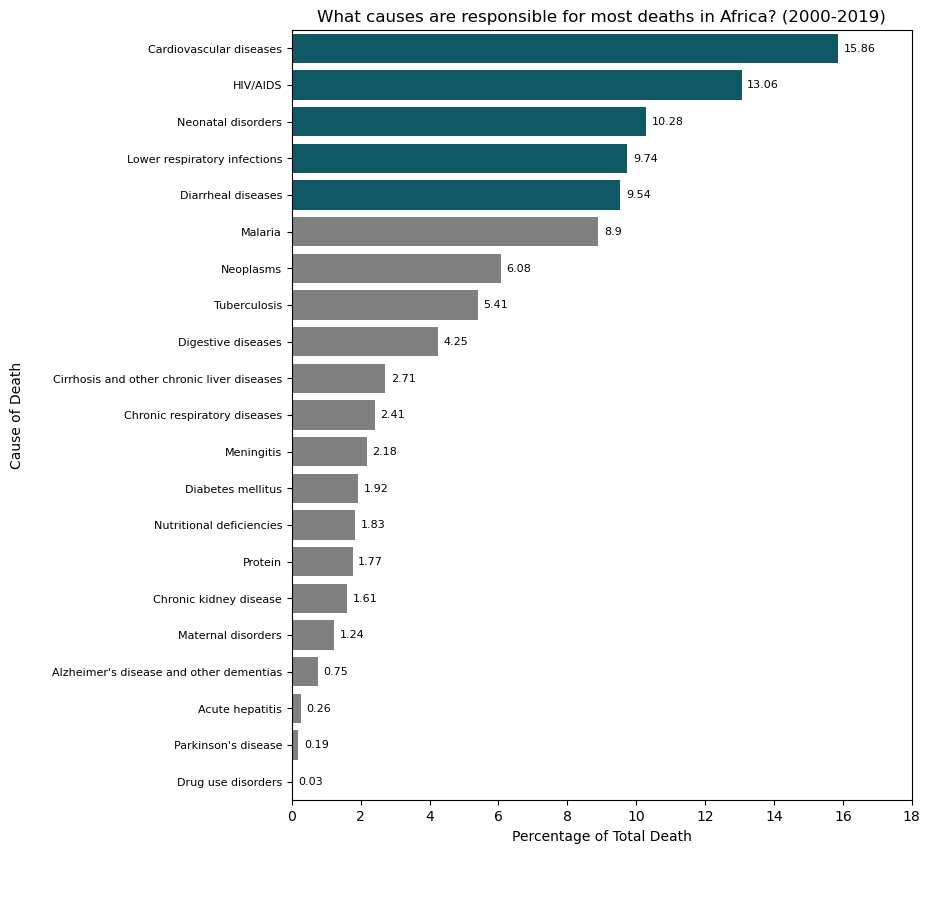

In [105]:
plotData = causes_casecount.Percentages

# bar color
bar_clrs = ['grey' if (x < 9) else base_color for x in plotData.values ]

plt.figure(figsize=[8,10])
ax = sns.barplot(y=plotData.index, x=plotData.values, palette=bar_clrs)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,18)
plt.xlabel('Percentage of Total Death\n\n\n')
plt.ylabel('Cause of Death', labelpad=20)
plt.yticks(fontsize=8)
plt.title('What causes are responsible for most deaths in Africa? (2000-2019)');

## What are top causes responsible for deaths in the top 5 Countries and Nigeria?

Lesotho, Swaziland and Zimbabwe have an average of 48% of deaths relating of HIV/AIDs. It's interesting to note that of the worst 5 countries, Lesotho, Eritrea and Swaziland have low deaths due to malaria. Lesotho has a 0% death rate for malaria because Lesotho is a [malaria free country](https://www.who.int/teams/global-malaria-programme/elimination/countries-and-territories-certified-malaria-free-by-who). 

Nigeria, on the other hand, has its highest death due to Malaria and Diarrheal diseases which is 16% each of the total deaths. Following after that are deaths due to Lower respiratory infections and neonatal diseases (14% and 13% respectively).

In [106]:
topCountries = ['Lesotho', 'Central African Republic', 'Eritrea', 'Swaziland', 'Zimbabwe', 'Nigeria']
causesofDeath_africa_topcountries = causesofDeath_africa.query('Country_Name in @topCountries')
agg_causesDeath_topcountries = causesofDeath_africa_topcountries.groupby(['Causes','Country_Name'])['Case_Count'].aggregate('sum').unstack()
agg_causesDeath_topcountries = agg_causesDeath_topcountries.reindex(labels=plotData.index)
agg_causesDeath_topcountries = agg_causesDeath_topcountries[topCountries]

# Let's normalize the df
agg_causesDeath_topcountries_PCT = agg_causesDeath_topcountries.div(agg_causesDeath_topcountries.sum())
agg_causesDeath_topcountries_PCT *= 100

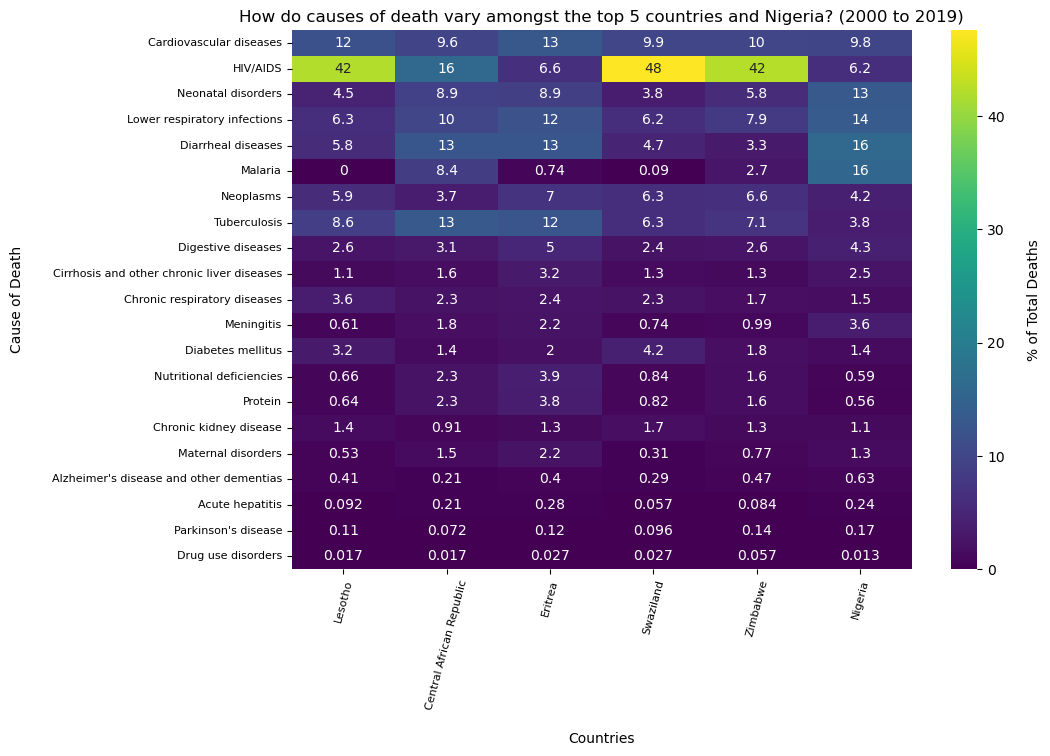

In [107]:
plt.figure(figsize=[10,7])
sns.heatmap(agg_causesDeath_topcountries_PCT, cmap='viridis', annot=True, cbar_kws={'label':'\n% of Total Deaths'})
plt.xticks(rotation=75)
plt.xlabel('Countries', labelpad=15)
plt.ylabel('Cause of Death', labelpad=20)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.title("How do causes of death vary amongst the top 5 countries and Nigeria? (2000 to 2019)");

## What is the yearly variation of the top 7 diseases?
We can see that HIV/AIDS was a serious problem for African countries with Lesotho, Swaziland and Zimbabwe reaching peaks of above 0.8% deaths per population, between 2002 and 2006, which surpassed the other causes of deaths by about 0.6%. 

Lesotho is a country known to be battling the HIV/AIDS epidemic which is fueled by behavioural, social and structural drivers and this explains its high percentage contribution. Some of this factors that drive this include the prevalence of multiple sexual partnerships combined with unsafe sexual practices, the abuse and sexual exploitation of women, etc. 

Unlike Lesotho, the other counties have experience a sharp fall in percentage contributions with most having values below 0.4%.

Source: [Government of Lesotho, Final Report for a Joint Review of HIV/Tuberculosis and Hepatitis programmes.](https://www.unaids.org/sites/default/files/country/documents/LSO_2018_countryreport.pdf)

In [108]:
worst7diseases = plotData.index[:7]
worst7diseases_africaDeaths = causesofDeath_africa_topcountries.query('Causes in @worst7diseases')
worst7diseases_africaDeaths['pct_deaths_per_pop'] = worst7diseases_africaDeaths.death_per_population * 100

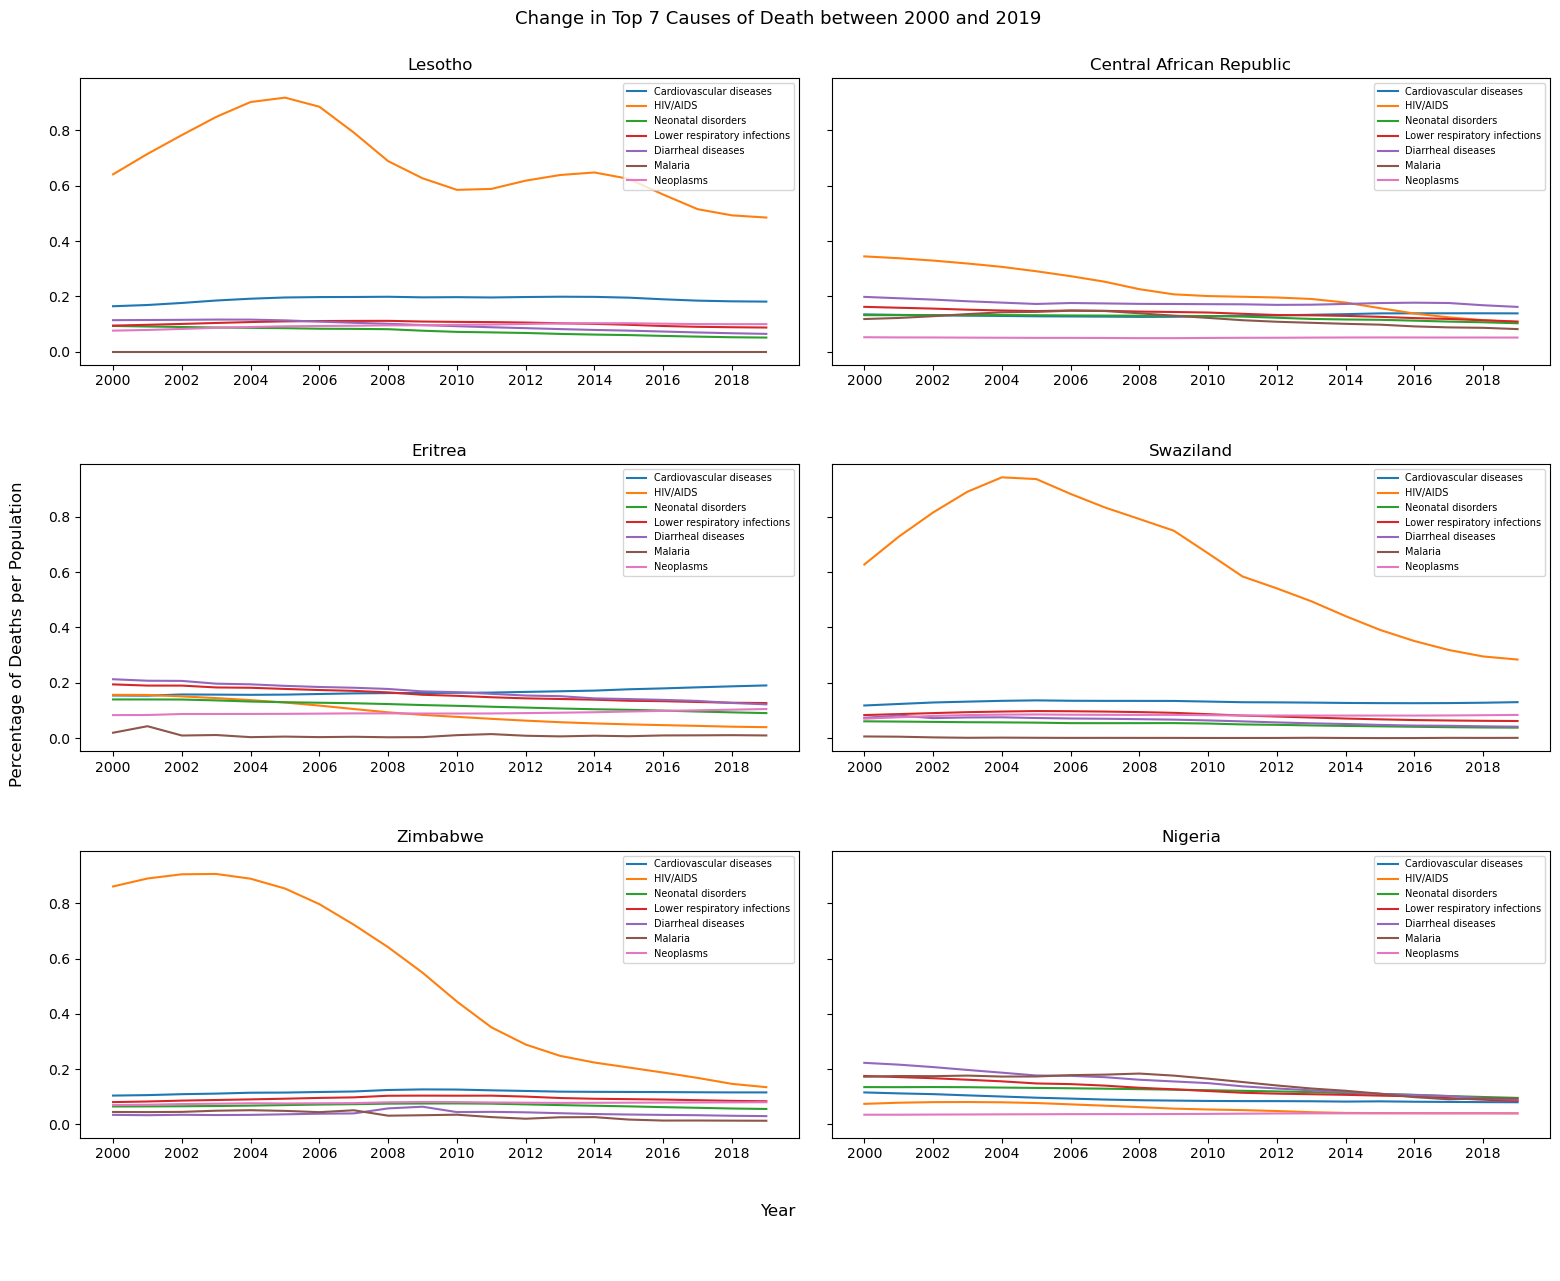

In [109]:
# resize figure to accommodate two plots
## plt.figure(figsize=[20,5])

fig, axes = plt.subplots(3, 2, sharex=False, sharey=True, figsize=(16, 13))
hue_order = worst7diseases
countries = ['Lesotho', 'Central African Republic', 'Eritrea', 'Swaziland', 'Zimbabwe', 'Nigeria']

# Use the axes for plotting
for i,j in enumerate(countries):
      if i < 2:
            plotData = worst7diseases_africaDeaths.query('Country_Name == @j')
            g = sns.lineplot(x='Year', y='pct_deaths_per_pop', data=plotData,
                        hue='Causes', hue_order=hue_order, palette='tab10',
                        ax=axes[0,i])
            g.legend(fontsize=7)
            axes[0,i].set_xlabel('')
            axes[0,i].set_ylabel('')
            axes[0,i].set_title(j)
      elif i < 4:
            plotData = worst7diseases_africaDeaths.query('Country_Name == @j')
            g = sns.lineplot(x='Year', y='pct_deaths_per_pop', data=plotData,
                        hue='Causes', hue_order=hue_order, palette='tab10',
                        ax=axes[1,i-2])
            g.legend(fontsize=7)
            #axes[0,0].set_yticks(ticks=np.arange(0,2,0.2))
            axes[1,i-2].set_xlabel('')
            axes[1,i-2].set_ylabel('')
            axes[1,i-2].set_title(j)
      else:
            plotData = worst7diseases_africaDeaths.query('Country_Name == @j')
            g = sns.lineplot(x='Year', y='pct_deaths_per_pop', data=plotData,
                        hue='Causes', hue_order=hue_order, palette='tab10',
                        ax=axes[2,i-4])
            g.legend(fontsize=7)
            axes[2,i-4].set_xlabel('')
            axes[2,i-4].set_ylabel('')
            axes[2,i-4].set_title(j)            
            

fig.supxlabel('Year\n\n\n')
fig.supylabel('Percentage of Deaths per Population')
fig.suptitle('Change in Top 7 Causes of Death between 2000 and 2019', fontsize=13)
fig.tight_layout(pad=2, h_pad=4)
 
plt.show()

## What is the yearly variation of the top 7 diseases in Nigeria?
There sharp decline in deaths due to Diarrheal diseases, Lower respiratory infections, and Malaria by an average of 53.2% between 2000 and 2019. Neonatal disorders, which is now top cause of death in 2019 and Cardiovascular diseases have relatively the same by just experiencing an average of 30% drop. While HIV/AIDS related deaths have dropped from 0.075% in 2000 to a bit below 0.050% in 2019, deaths due to Neoplasms seem to be on the increase steadily, having a value of 0.035% in 2000, it has increased to 0.04 in 2019.

Nigeria needs to place emphasis on Antenatal and Postnatal cares for mothers and deaths due to Neoplasms need to be checkmated as it is gradually on the rise.

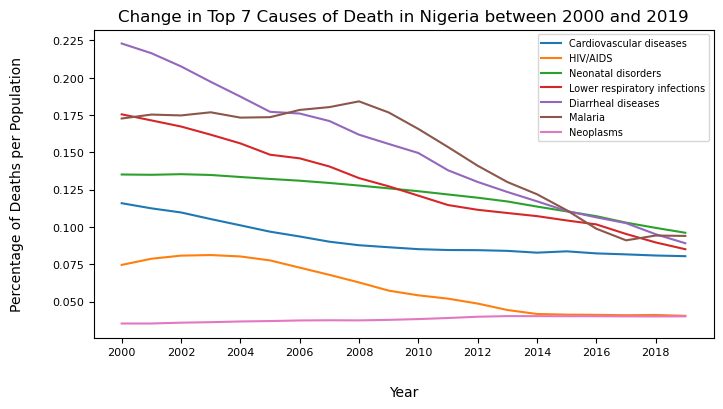

In [110]:
plotData = worst7diseases_africaDeaths.query('Country_Name == "Nigeria"')

plt.figure(figsize=[8,4])
g = sns.lineplot(x='Year', y='pct_deaths_per_pop', data=plotData,
                 hue='Causes', hue_order=hue_order, palette='tab10')
g.legend(fontsize=7)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('Year', labelpad=20)
plt.ylabel('Percentage of Deaths per Population', labelpad=20)
plt.title('Change in Top 7 Causes of Death in Nigeria between 2000 and 2019');

## What is the distribution of deaths among the age groups in Africa?
Majority of the deaths in Africa, which is approximately 60%, occured in the 'Under 5 years' (34.58%) and '15-49 years' (24.55%) age groups. Deaths amongst babies appears to be a huge concern in the African countries however, there is a considerably low percentage of '5-14 years' deaths with just 3.16% of deaths per population. Deaths occuring between 50 and 69 years, and 70+ years appears similar having an average value of 18.86%. 

More children and youths are dying compared to the older ones.

In [111]:
ageGroupDeaths_merge = pd.merge(left=ageGroupDeaths, right=worldCountries, how='inner', left_on='Code', right_on='Three_Letter_Country_Code')
ageGroupDeaths_merge = ageGroupDeaths_merge.drop(labels=['Entity', 'Country_Number'], axis=1)
ageGroupDeaths_merge = ageGroupDeaths_merge.iloc[:,[6,1,2,3,7,8,4,5]]

# Let's merge the worldPopulation data to `ageGroupDeaths_merge`
ageGroupDeaths_merge['Year_str'] = ageGroupDeaths_merge.Year.dt.year.astype('str')
ageGroupDeaths_merge['Key'] = ageGroupDeaths_merge['Three_Letter_Country_Code']+ageGroupDeaths_merge['Year_str']
ageGroupDeaths_merge = pd.merge(left=ageGroupDeaths_merge, right=worldPopulation.iloc[:,[3,5]], how='inner', on='Key')
ageGroupDeaths_merge = ageGroupDeaths_merge.drop(labels=['Year_str', 'Key'], axis=1)
ageGroupDeaths_merge['death_per_population'] = ageGroupDeaths_merge['Death_Count']/ageGroupDeaths_merge['Population (historical estimates)']
ageGroupDeaths_africa = ageGroupDeaths_merge.query('Continent_Name == "Africa"')

In [112]:
plotData = ageGroupDeaths_africa.groupby('Age_Group').sum()
plotData['pct_death_per_population'] = plotData['death_per_population'] * 100 /plotData['death_per_population'].sum()
plotData['pct_death_per_population'] = plotData['pct_death_per_population'].round(2)
plotData = plotData.reset_index()

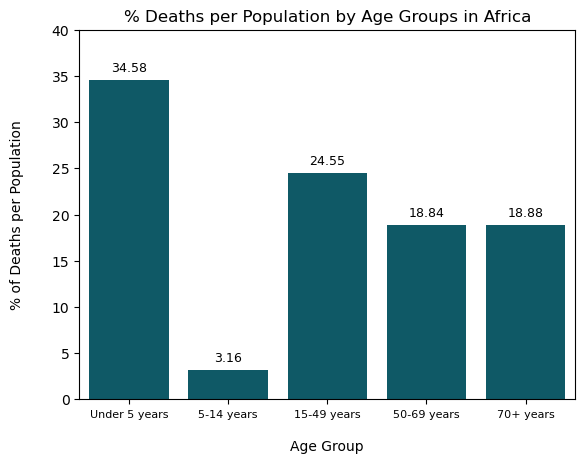

In [113]:
ax = sns.barplot(x='Age_Group', y='pct_death_per_population', data=plotData, color=base_color)
ax.bar_label(ax.containers[0], padding=4, fontsize=9)
plt.ylim(0,40)
plt.xlabel('Age Group', labelpad=15)
plt.ylabel('% of Deaths per Population', labelpad=20)
plt.xticks(fontsize=8)
plt.title('% Deaths per Population by Age Groups in Africa');

## What is the distribution of deaths among the age groups in Nigeria?
Nigeria recorded a higher percentage of 55.89% for deaths on under 5 years than that of Africa which was 34.58%. Generally, the deaths for all other groups experienced an 32.5% drop averagely when compared to the values for Africa.

In [114]:
# get the deaths per age group for Nigeria
## ideally, you should have done this with the ageGroupDeaths data to avoid code repetition.
ageGroupDeaths_Nigeria = ageGroupDeaths_africa.query("Country_Name == 'Nigeria'")
ageGroupDeaths_Nigeria['pct_death_per_population'] = ageGroupDeaths_Nigeria['death_per_population'] * 100 /ageGroupDeaths_Nigeria['death_per_population'].sum()
ageGroupDeaths_Nigeria['pct_death_per_population'] = ageGroupDeaths_Nigeria['pct_death_per_population'].round(2)

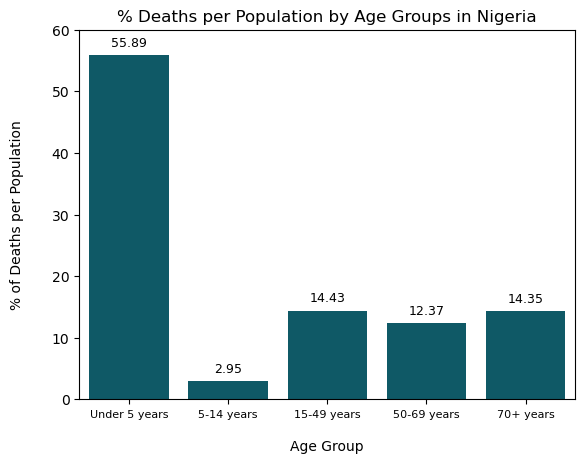

In [115]:
plotData = ageGroupDeaths_Nigeria.groupby('Age_Group').sum()
plotData = plotData.reset_index()

ax = sns.barplot(x='Age_Group', y='pct_death_per_population', data=plotData, color=base_color)
ax.bar_label(ax.containers[0], padding=4, fontsize=9)
plt.ylim(0,60)
plt.xlabel('Age Group', labelpad=15)
plt.ylabel('% of Deaths per Population', labelpad=20)
plt.xticks(fontsize=8)
plt.title('% Deaths per Population by Age Groups in Nigeria');

## What is change in distribution of deaths by age groups in Nigeria between 2000 and 2019?
When looking at the yearly change in percentage of deaths per population by age groups in Nigeria, we can see that deaths for the 'Under 5 years' have dropped drastically, although it is still high. From a bit above 3.5% in 2000 to 1.76% in 2019. Percentage of deaths per population for age groups 15-49 years, 50-69 years and 70+ years have remained steady over the years having a range of 0.5% to 1.0% while age group 5-14 years remained steadily low with an average value of 0.15%. 

Priority needs to be placed on further reducing the deaths of babies while also reducing the deaths of the other age groups which have remained steady.

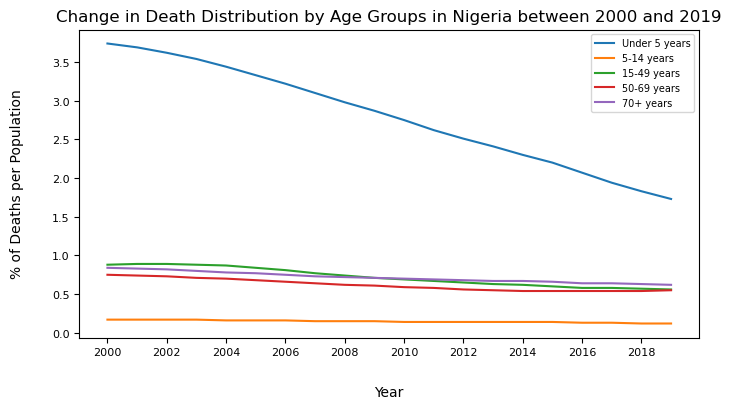

In [116]:
plt.figure(figsize=[8,4])
g = sns.lineplot(x='Year', y='pct_death_per_population', data=ageGroupDeaths_Nigeria,
                 hue='Age_Group', palette='tab10')
g.legend(fontsize=7)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('Year', labelpad=20)
plt.ylabel('% of Deaths per Population', labelpad=20)
plt.title('Change in Death Distribution by Age Groups in Nigeria between 2000 and 2019');

## What is distribution of Medical Doctors per 10,000 people in African Countries?
This chart illustrates the lack of medical doctors all across Africa. Only Algeria, Mauritius and Seychelles have more than 10 doctors per 10,000 people. While a shocking 76.6% of the countries have below 2 doctors per 10,000 people. 

This is a major cause for concern seeing that these numbers are reducing as more doctors are leaving their respective countries in Africa to look for better opportunities overseas. Each African government needs to formulate policies that would favor their doctors by improving the quality of education, building relevant and well equipped health facilites, and increasing the pay for doctors. Medical doctors in Nigeria earn an average of 3,600,000 NGN annually (6634.72 GBP) while their counterparts in UK earn an average of 76,300 GBP. This alone serves as a enough push factor for the doctors.

In [117]:
doctorsPerPopulation.query('ParentLocation == "Africa"').Indicator.value_counts()
doctorsPerPopulation_africa = doctorsPerPopulation.query('ParentLocation == "Africa" & Indicator == "Medical doctors (per 10,000)"')

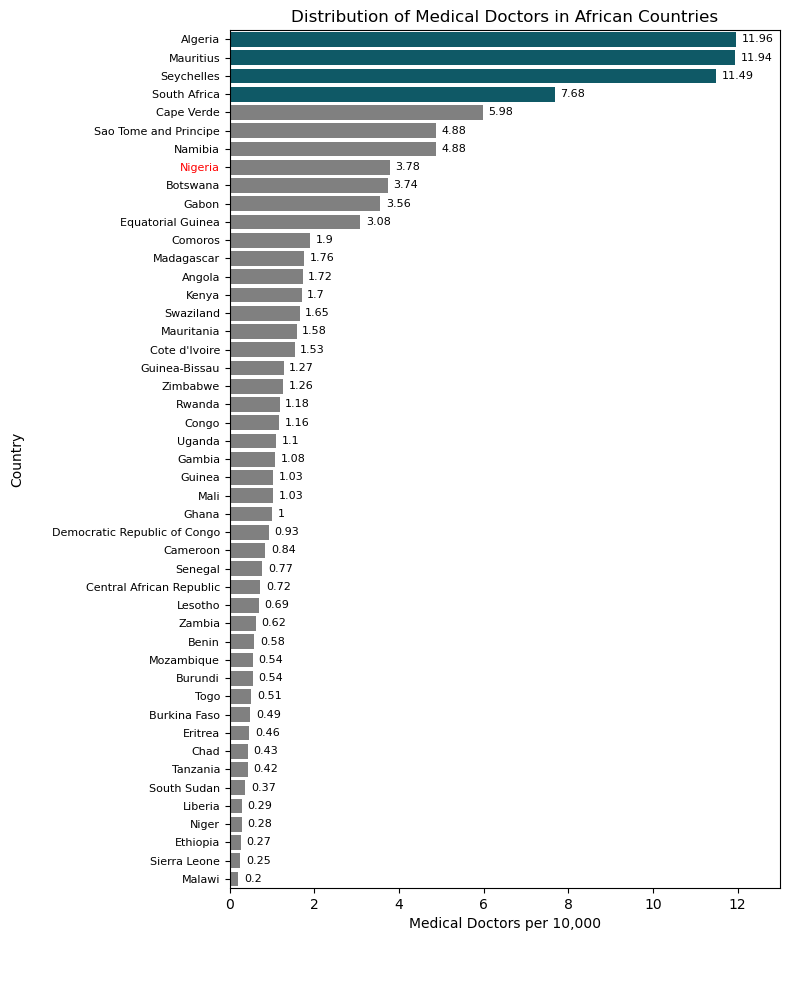

In [118]:
plotData = doctorsPerPopulation_africa.groupby('Location').median().reset_index()
plotData['FactValueNumeric'] = plotData.FactValueNumeric.round(2)
plotData = plotData.sort_values(by='FactValueNumeric', ascending=False)

# bar color
bar_clrs = ['grey' if (x < 7) else base_color for x in plotData.FactValueNumeric ]

plt.figure(figsize=[8,10])
ax = sns.barplot(y='Location', x='FactValueNumeric', data=plotData, palette=bar_clrs)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,13)
plt.xlabel('Medical Doctors per 10,000\n\n\n')
plt.ylabel('Country', labelpad=20)
plt.yticks(fontsize=8)
plt.title('Distribution of Medical Doctors in African Countries')
plt.tight_layout()

# change tick color
ytick_clrs = ['red' if (x == 'Nigeria') else 'black' for x in plotData.Location ]

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), ytick_clrs):
      ticklabel.set_color(tickcolor)
      
plt.show()

## What is distribution of Health Expenditure per 10,000 people in African Countries?

Sierra Leone has the highest health expenditure of 11.88% of GDP followed by Namibia which lags at 9.51%. Majority of the countries have their health expenditures below 7% with Congo, Equatorial Guinea, Benin, Angola and Gabon having below 3% health expenditure. Nigeria performs poorly with a health expenditure of 3.62%.

This suggests that governments need to allocate more resources towards the health sector.

In [119]:
healthExpenditure_africa = healthExpenditure.query('Country_Code in @africanCountries.Three_Letter_Country_Code')

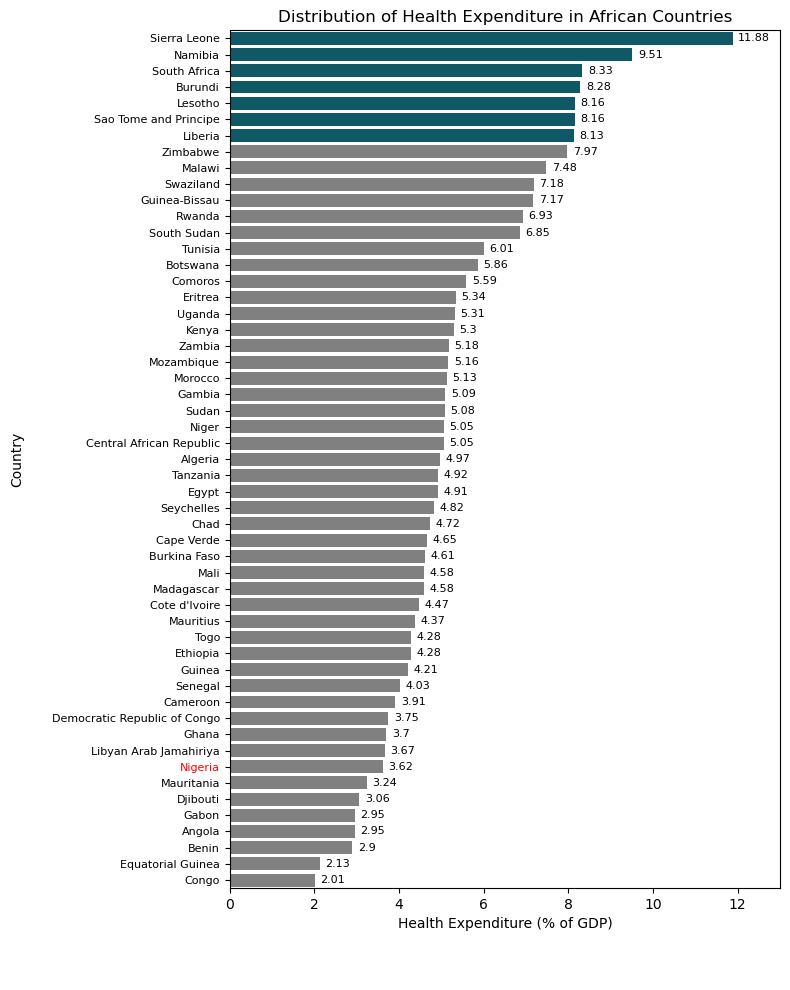

In [120]:
plotData = healthExpenditure_africa.groupby('Country Name').mean().reset_index()
plotData = plotData.dropna()
plotData['Health Expenditure (% of GDP)'] = plotData['Health Expenditure (% of GDP)'].round(2)
plotData = plotData.sort_values(by='Health Expenditure (% of GDP)', ascending=False)

# bar color
bar_clrs = ['grey' if (x < 8) else base_color for x in plotData['Health Expenditure (% of GDP)'] ]

plt.figure(figsize=[8,10])
ax = sns.barplot(y='Country Name', x='Health Expenditure (% of GDP)', data=plotData, palette=bar_clrs)
ax.bar_label(ax.containers[0], padding=4, fontsize=8)
plt.xlim(0,13)
plt.xlabel('Health Expenditure (% of GDP)\n\n\n')
plt.ylabel('Country', labelpad=20)
plt.yticks(fontsize=8)
plt.title('Distribution of Health Expenditure in African Countries')
plt.tight_layout()

# change tick color
ytick_clrs = ['red' if (x == 'Nigeria') else 'black' for x in plotData['Country Name'] ]

for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), ytick_clrs):
      ticklabel.set_color(tickcolor)
      
plt.show()

## Summary of Findings
* 30.68% of the population in Africa are estimated to have been lost due to health issues which is higher than all other continents. It's worth nothing that South America and Oceania both have low deaths per population. Further research can be done to highlight why this is so and how this can be replicated in the top 3 continents. We'll focus on Africa for this analysis.
* Lesotho, Central African Republic and Eritrea are the worst performing countries in African with an estimated deaths per population of 3.51%, 3.03% and 2.88% respectively. Nigeria had the 20th position with 2.05% of its population dead due to health related uses. Libya, Algeria and Tunisia had the least % deaths per population with 0.7%, 0.87% and 1.03% respectively.
* For the period of 2000 to 2019, Cardiovascular diseases (15.86%) and HIV/AIDS (13.06%) have been responsible for most health related deaths in Africa. It is shocking to see Neonatal disorders accounts for 10.28% of the total deaths.  The least causes of deaths are Drug use disorders, Parkinson's disease and Acute hepatitis which account for just 0.45% of the total deaths.


* Lesotho is a country known to be battling the HIV/AIDS epidemic which is fueled by behavioural, social and structural drivers and this explains its struggle to bring its contribution to deaths below 0.4%. Some of the factors that drive this include the prevalence of multiple sexual partnerships combined with unsafe sexual practices, the abuse and sexual exploitation of women, etc. 
* More children and youths are dying compared to the older ones, as majority of the deaths in Africa, which is approximately 60%, occured in the 'Under 5 years' (34.58%) and '15-49 years' (24.55%) age groups.
* There is a lack of medical doctors all across Africa. Only Algeria, Mauritius and Seychelles have more than 10 doctors per 10,000 people. While a shocking 76.6% of African countries have below 2 doctors per 10,000 people. 
* Sierra Leone has the highest health expenditure of 11.88% of GDP followed by Namibia which lags at 9.51%. Majority of the countries have their health expenditures below 7% with Congo, Equatorial Guinea, Benin, Angola and Gabon having below 3% health expenditure. Nigeria performs poorly with a health expenditure of 3.62%.

## Recommendations
* It's worth nothing that South America and Oceania both have low deaths per population. Further research can be done to highlight why this is so and how this can be replicated in the top 3 continents. We'll focus on Africa for this analysis.
* Special attention needs to placed on Postnatal care and Maternal care as neonatal disorders accounts for 10.28% of the total deaths.
* Sexual education, women empowerment and other governmental policies should be enforced in Lesotho and other countries struggling with HIV/AID.
* Child health care needs to be improved in Africa as approximately 60% of the deaths in Africa are made up mostly children and youths.
* Each African government needs to formulate policies that would favor their doctors by improving the quality of education, building relevant and well equipped health facilites, and increasing the pay for doctors, thereby hindering the outflux of African doctors.
* Governments need to allocate more resources towards the health sector.

## References
* [Government of Lesotho, Final Report for a Joint Review of HIV/Tuberculosis and Hepatitis programmes.](https://www.unaids.org/sites/default/files/country/documents/LSO_2018_countryreport.pdf)
* *Countries and territories certified malaria-free by WHO.* (n.d.). https://www.who.int/teams/global-malaria-programme/elimination/countries-and-territories-certified-malaria-free-by-who

In [121]:
!jupyter nbconvert slide_deck.ipynb --to slides --post serve --no-input --no-prompt --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook slide_deck.ipynb to slides
[NbConvertApp] Writing 1824378 bytes to slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\Cyriaque Matthews\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Cyriaque Matthews\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Cyriaque Matthews\anaconda3\Scripts\jupyter-nbconvert.EXE\__main__.py", line 7, in <module>
  File "C:\Users\Cyriaque Matthews\anaconda3\lib\site-packages\jupyter_core\application.py", line 269, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "C:\Users\Cyriaque Matthews\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\Cyriaque Matthews\anaconda3\lib\site-pac